# Synthetic strong gravitational lens injection Demo

This notebook shows how to insert synthetic lensed sources behind DC2 and Rubin images.


Owner: **Rémy Joseph** ([@herjy](https://github.com/herjy/DESC-Lamp))
<br>Last Verified to Run: **2021-11-22** (by @herjy)

This early version of the demo aims at generating a lensed source galaxy image with an arbitrary lens profile and insert it in the background of an existing DC2 image of a galaxy at the coadd level. 

The content of this notebook builds up on the sythetic sourrce injection (example notebook){https://github.com/LSSTDESC/ssi-tools/blob/main/examples/DC2_calexp_injection.ipynb} by Josh Meyers inn the ssi tools packa

### Logistics
This is intended to be runnable at NERSC through the https://jupyter.nersc.gov interface from a local git clone of https://github.com/herjy/DESC-Lamp in your NERSC directory.  But you can also run it wherever, with appropriate adjustment of the 'repo' location to point to a place where you have a Butler repo will all of the images. 

This notebook uses the `desc-stack-weekly-latest` kernel. Instructions for setting up the proper DESC python kernel can be found here: https://confluence.slac.stanford.edu/x/o5DVE

In [10]:

# A few common packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D

import pandas as pd
%matplotlib inline

# We will use astropy's WCS and ZScaleInterval for plotting
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
# Also to convert sky coordinates
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
import astropy.io.fits as fits

# We will use several stack functions
import lsst.geom as geom
import lsst.afw.display as afwDisplay
import lsst.afw.display.rgb as rgb
from lsst.daf.persistence import Butler
from lsst.skymap import makeSkyPolygonFromBBox

# And also DESC packages to get the data path
import GCRCatalogs
from GCRCatalogs import GCRQuery
import desc_dc2_dm_data

# Synthtice source injection required packages
import mpl_toolkits.axisartist.floating_axes as floating_axes
from mpl_toolkits.axisartist.grid_finder import DictFormatter, MaxNLocator
from desc_dc2_dm_data import REPOS
from tqdm import tqdm
import galsim



## Setup 
Fetchinng Butler for deep coadd of run 2.2i dr6, wide field deep. and extracting cutout information for a given location

In [6]:
butler = Butler(REPOS['2.2i_dr6_wfd'])

skymap = butler.get("deepCoadd_skyMap")

# Near the center of DC2
ra = 65.0  # degrees
dec = -35.0 # degrees
point = geom.SpherePoint(ra, dec, geom.degrees)
cutoutSize = geom.ExtentI(201, 201)

tractInfo = skymap.findTract(point)
patchInfo = tractInfo.findPatch(point)
xy = geom.PointI(tractInfo.getWcs().skyToPixel(point))
bbox = geom.BoxI(xy - cutoutSize//2, cutoutSize)
coaddId = {
    'tract':tractInfo.getId(), 
    'patch':f"%d,%d"%patchInfo.getIndex(),
    'filter':'r'
}
coadd = butler.get("deepCoadd_sub", bbox=bbox, immediate=True, dataId=coaddId)



In [7]:
# Get visits contributing to this cutout
visitIds = []
for ccd in tqdm(coadd.getInfo().getCoaddInputs().ccds):
    dataId = {
        'visit':ccd['visit'], 
        'detector':ccd['ccd'], 
        'filter':ccd['filter'],
        'tract':tractInfo.getId()
    }
    wcs = butler.get('calexp_wcs', dataId=dataId)   # Note 99% of cell execution time is this line and the next
    bbox = butler.get('calexp_bbox', dataId=dataId)
    poly = makeSkyPolygonFromBBox(bbox, wcs)
    if poly.contains(point.getVector()):
        visitIds.append(dataId)



100%|██████████| 519/519 [01:02<00:00,  8.29it/s]


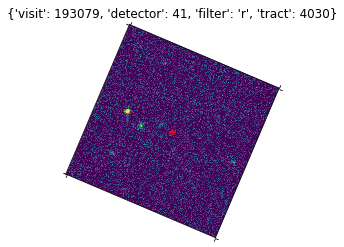

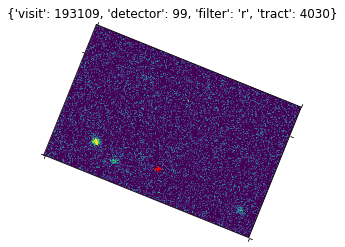

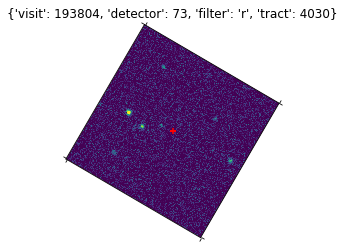

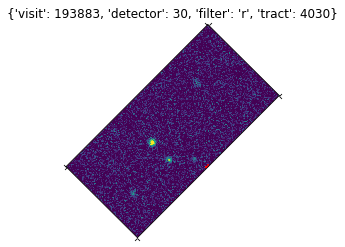

In [9]:
plt.close('all')

# Get image cutouts
n_max_cutout = 4

for dataId in visitIds[:n_max_cutout]:
    wcs = butler.get('calexp_wcs', dataId=dataId)
    bbox = butler.get('calexp_bbox', dataId=dataId)
    xy = geom.PointI(wcs.skyToPixel(point))
    cutout = geom.BoxI(xy - cutoutSize//2, cutoutSize)
    bbox.clip(cutout)
    image = butler.get("calexp_sub", bbox=bbox, immediate=True, dataId=dataId)

    mat = np.eye(3)
    mat[:2,:2] = wcs.getCdMatrix()
    transform = Affine2D(mat)
    
    fig = plt.figure()
    arr = image.maskedImage.image.array
    plot_extents = 0, bbox.width, 0, bbox.height
    helper = floating_axes.GridHelperCurveLinear(
        transform, plot_extents, 
        tick_formatter1=DictFormatter({}),
        tick_formatter2=DictFormatter({}),
        grid_locator1=MaxNLocator(nbins=1),
        grid_locator2=MaxNLocator(nbins=1),
    )
    ax = floating_axes.FloatingSubplot(fig, 111, grid_helper=helper)
    ax.imshow(arr, vmin=0, vmax=300, transform=transform+ax.transData)
    ax.set_title(repr(dataId))
    ax.scatter(
        xy.x - bbox.minX, 
        xy.y - bbox.minY, 
        c='r', marker='+', transform=transform+ax.transData
    )
    fig.add_subplot(ax)
    fig.show()


In [11]:
# Not sure if all of these are needed.
table = Table()
table['raJ2000'] = np.array([np.deg2rad(65.0)])
table['decJ2000'] = np.array([np.deg2rad(-35.0)])
table['sourceType'] = np.array(["galaxy"])
table['DiskHalfLightRadius'] = np.array([2.0])
table['BulgeHalfLightRadius'] = np.array([2.0])
table['umagVar'] = np.array([19.0])
table['gmagVar'] = np.array([19.0])
table['rmagVar'] = np.array([19.0])
table['imagVar'] = np.array([19.0])
table['zmagVar'] = np.array([19.0])
table['ymagVar'] = np.array([19.0])
table['disk_n'] = np.array([1.0])
table['bulge_n'] = np.array([3.0])
table['a_d'] = np.array([4.0])
table['a_b'] = np.array([4.0])
table['b_d'] = np.array([1.0])
table['b_b'] = np.array([1.0])
table['pa_disk'] = np.array([35.0])
table['pa_bulge'] = np.array([55.0])

table.write("fsi.fits", overwrite=True)



In [12]:
n_max_cutout = 4
for dataId in visitIds[:n_max_cutout]:
    visit = dataId['visit']    
    detector = dataId['detector']
    !processCcdWithFakes.py /global/cfs/cdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1 \
      --output test \
      --id visit=$visit detector=$detector \
      -c insertFakes.fakeType=fsi.fits \
      --clobber-config --no-versions

/usr/bin/sh: processCcdWithFakes.py: command not found
/usr/bin/sh: processCcdWithFakes.py: command not found
/usr/bin/sh: processCcdWithFakes.py: command not found
/usr/bin/sh: processCcdWithFakes.py: command not found


In [13]:


fakes_butler = Butler("test/")



RuntimeError: No default mapper could be established from inputs:[] and no mapper specified for outputs:[RepoData(id=46914688027336,repoArgs=RepositoryArgs(root='/global/u2/r/remyj/DESC-Lamp/notebooks/test', cfgRoot=None, mapper=None, mapperArgs=None, tags=set(), mode='rw', policy=None)cfg=RepositoryCfg(root='/global/u2/r/remyj/DESC-Lamp/notebooks/test', mapper=None, mapperArgs={}, parents=[], policy=None),cfgOrigin=new,cfgRoot=/global/u2/r/remyj/DESC-Lamp/notebooks/test,repo=None,parentRepoDatas=[],isV1Repository=False,role=output,parentRegistry=None)]